MIT License

Copyright (c) 2018, [Savera.ai](https://www.savera.ai/), [Jitender Singh Virk](https://www.linkedin.com/in/jsv47/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

In [11]:
"""
SAVERA SINGLE USER ROOFTOP DETECTION PROCESS

Author: Jitender Singh Virk
Copyright: Savera.ai
Date: 29 November, 2018
""";

In [12]:
import googlemaps
import cv2
from PIL import Image
from datetime import datetime
from io import BytesIO
import requests
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline

In [13]:
SC = 'YOUR GOOGLE CLOUD SECRET KEY'
static_api_url = 'https://maps.googleapis.com/maps/api/staticmap?'

In [43]:
address = 'Kaleidoscope, Tilak Marg, Ashok Nagar, C Scheme, Ashok Nagar, Jaipur, Rajasthan'
# address = 'A/31, Block A, Sanwal Nagar, Sadiq Nagar, New Delhi, Delhi 110049A/31, Block A, Sanwal Nagar, Sadiq Nagar, New Delhi, Delhi 110049'
zoom = '19'
imgsize = '300x300'
maptype = 'satellite'
scale = '2'

In [44]:
query = '{}center={}&zoom={}&size={}&maptype={}&scale={}&key={}'.format(static_api_url,
                                                               address, zoom,
                                                               imgsize, maptype,
                                                                        scale, SC
                                                              )

#### Image processing parameters

In [45]:
# FACTOR TO CONTROL THE SIZE OF SELECTION CIRCLE
CIRCLE_SIZE = int(zoom)
ORIGINAL_IMG_SHAPE = (300, 300, 3)
ORIGINAL_IMG_DIMS = (300, 300)
INP_IMG_SHAPE = (256, 256, 3)
INP_IMG_DIMS = (256, 256)

### Lat-Lng coords of address

In [46]:
gmaps = googlemaps.Client(key=SC)
# Geocoding an address
geocode_result = gmaps.geocode(address)
geocode_result[0]['geometry']

{'location': {'lat': 26.907767, 'lng': 75.801943},
 'location_type': 'ROOFTOP',
 'viewport': {'northeast': {'lat': 26.9091159802915, 'lng': 75.80329198029149},
  'southwest': {'lat': 26.9064180197085, 'lng': 75.80059401970848}}}

### Map of given address

In [47]:
# REQUEST IMAGE
response = requests.get(query)
response.raise_for_status()

In [48]:
image = np.array(Image.open(BytesIO(response.content)).convert("RGB"))[:-40,...]
image = cv2.resize(image, ORIGINAL_IMG_DIMS)

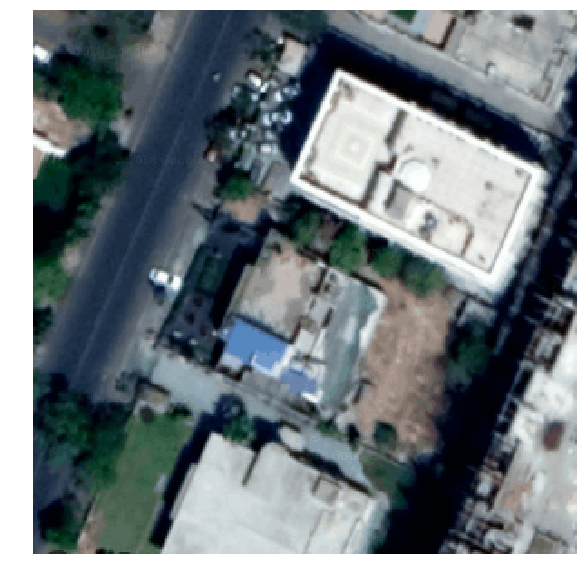

In [49]:
# DISPLAY IMAGE
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off');

### Input image preprocessing

In [50]:
# GET IMAGE READY FOR PREDICTION
inp_img = cv2.resize(image, INP_IMG_DIMS) / 255
inp_img = np.expand_dims(inp_img, 0)
print(inp_img.shape)

(1, 256, 256, 3)


Text(0.5,1,'Model input image')

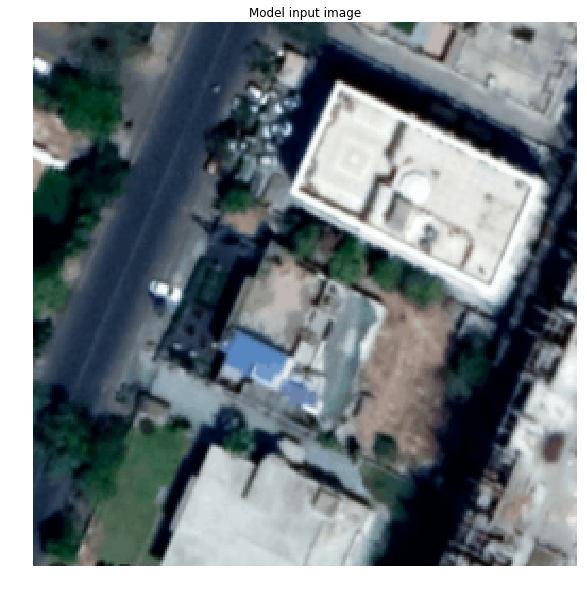

In [51]:
plt.figure(figsize=(10,10))
plt.imshow(inp_img.reshape(INP_IMG_SHAPE))
plt.axis('off')
plt.title('Model input image')

### Load Model for segmentation

In [52]:
import tensorflow.keras.backend as K
## intersection over union
def IoU(y_true, y_pred, eps=1e-6):
    if np.max(y_true) == 0.0:
        return IoU(1-y_true, 1-y_pred) ## empty image; calc IoU of zeros
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return -K.mean( (intersection + eps) / (union + eps), axis=0)

In [53]:
from tensorflow.keras.models import load_model
model = load_model("SAVERA_597_chkpt/SAVERA_597_trained_full_model.h5", custom_objects={
    'IoU':IoU,
})

In [54]:
pred_mask = model.predict(inp_img).reshape(INP_IMG_DIMS)

Text(0.5,1,'Predicted mask')

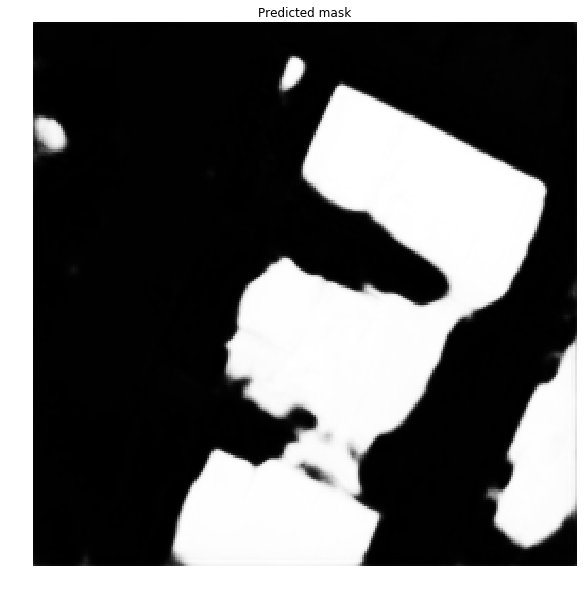

In [55]:
# SHOW PREDICTIONS
plt.figure(figsize=(10,10))
plt.imshow(pred_mask, cmap='gray')
plt.axis('off')
plt.title('Predicted mask')

In [17]:
# img_path = 'SAVERA_FIXED_DATA/ROOFs/SVRROOF_50.png'
# image = (plt.imread(img_path)*255).astype(np.uint8)
# plt.imshow(image)
# # LOAD ANNOTATION
# mask_path = 'SAVERA_FIXED_DATA/MASKs/SVRMASK_50.png'
# pred_mask = plt.imread(mask_path)
# pred_mask = cv2.cvtColor(pred_mask, cv2.COLOR_RGBA2GRAY)
# plt.imshow(pred_mask, cmap='gray')
# pred_mask.shape

In [56]:
# RESIZE PREDICTED MASK TO ORIGINAL IMAGE SHAPE
resized_mask = (cv2.resize(pred_mask, ORIGINAL_IMG_DIMS)*255).astype(np.uint8)

In [57]:
# Check if mask is aligned with given image
check_img = cv2.addWeighted(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), 0.3, resized_mask, 0.7, 0)

Text(0.5,1,'mask verfication')

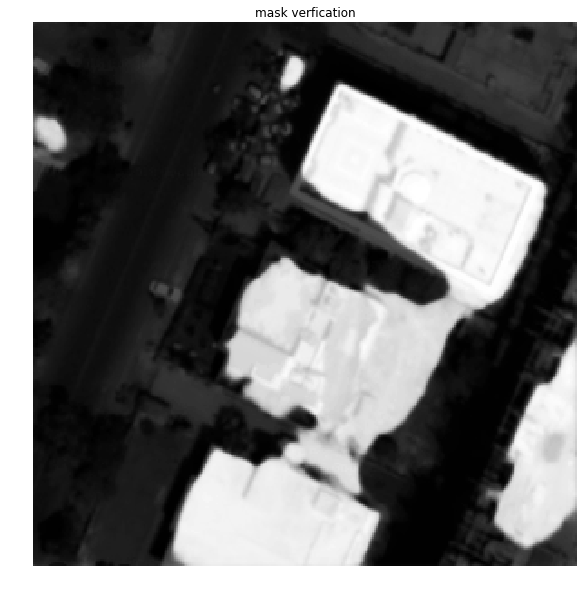

In [58]:
# SHOW PREDICTIONS
plt.figure(figsize=(10,10))
plt.imshow(check_img, cmap='gray')
plt.axis('off')
plt.title('mask verfication')

## Post processing with WaterShed

In [59]:
# import the necessary packages
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage

In [60]:
img = image.copy()

In [76]:
thresh = cv2.threshold(resized_mask, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# APPLYING OPENING MORPHOLOGY
m_kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(7,7))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, m_kernel, iterations=4)
print('thresh shape:', thresh.shape)

thresh shape: (300, 300)


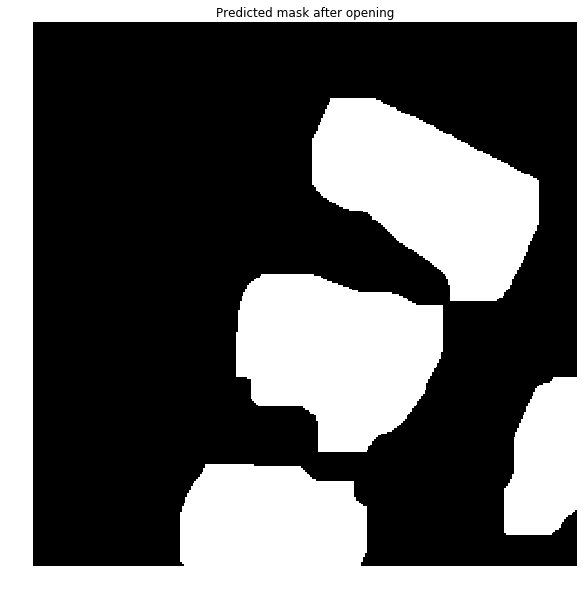

In [77]:
# DISPLAY IMAGE
plt.figure(figsize=(10,10))
plt.imshow(thresh, cmap='gray')
plt.axis('off')
plt.title('Predicted mask after opening');

Text(0.5,1,'Distance transform')

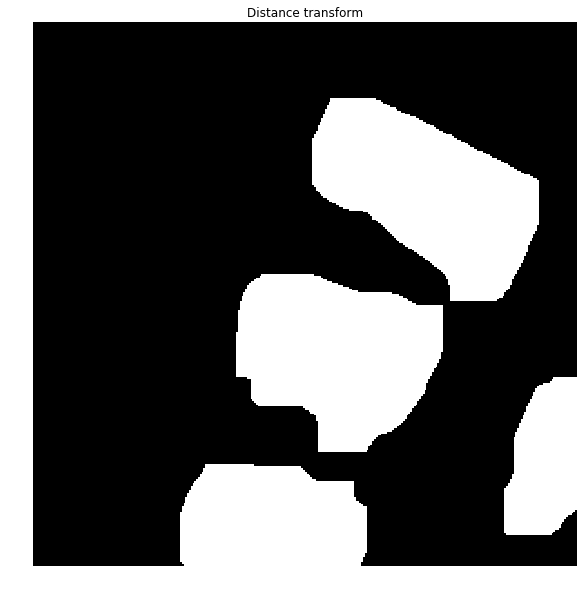

In [78]:
# compute the exact Euclidean distance from every binary
# pixel to the nearest zero pixel
D = thresh#ndimage.distance_transform_edt(thresh)
# DISPLAY IMAGE
plt.figure(figsize=(10,10))
plt.imshow(D, cmap='gray')
plt.axis('off')
plt.title("Distance transform")

In [79]:
# then find peaks in this distance map
localMax = peak_local_max(D, indices=False, min_distance=1,labels=thresh)

Text(0.5,1,'PEAKS')

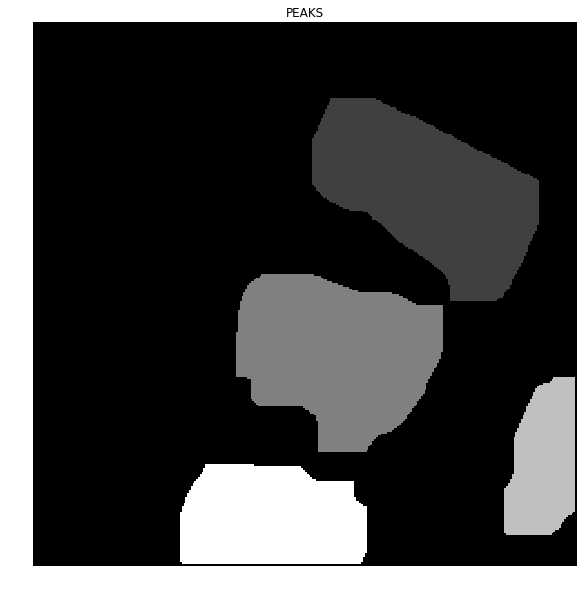

In [80]:
# perform a connected component analysis on the local peaks, using 8-connectivity
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
# DISPLAY IMAGE
plt.figure(figsize=(10,10))
plt.imshow(markers, cmap='gray')
plt.axis('off')
plt.title("PEAKS")

[INFO] 4 unique segments found


(300, 300)

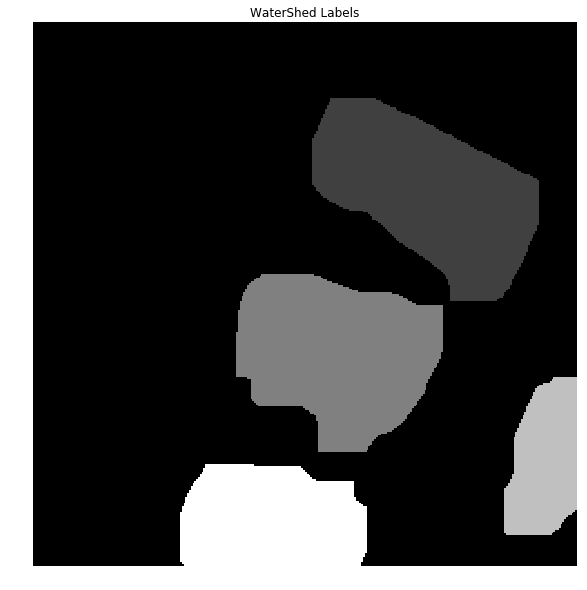

In [81]:
# apply the Watershed algorithm
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))
# DISPLAY IMAGE
plt.figure(figsize=(10,10))
plt.imshow(labels, cmap='gray')
plt.axis('off')
plt.title("WaterShed Labels")
labels.shape

### Get the location of user's house by mouse double click

In [82]:
coords = []
# mouse callback function
def get_coords(event,x,y,flags,param):
    if event == cv2.EVENT_LBUTTONDBLCLK:
        print("clicked at (x={}, y={})".format(x, y))
        coords.append((x, y))

cv2.namedWindow('image')
cv2.setMouseCallback('image',get_coords)

while(1):
    cv2.imshow('image', image) #,cv2.resize(cv2.cvtColor(image, cv2.COLOR_RGB2BGR), (600, 600))
    if cv2.waitKey(20) & 0xFF == 27:
        cv2.destroyAllWindows()
        break

clicked at (x=152, y=164)


(300, 300, 3)


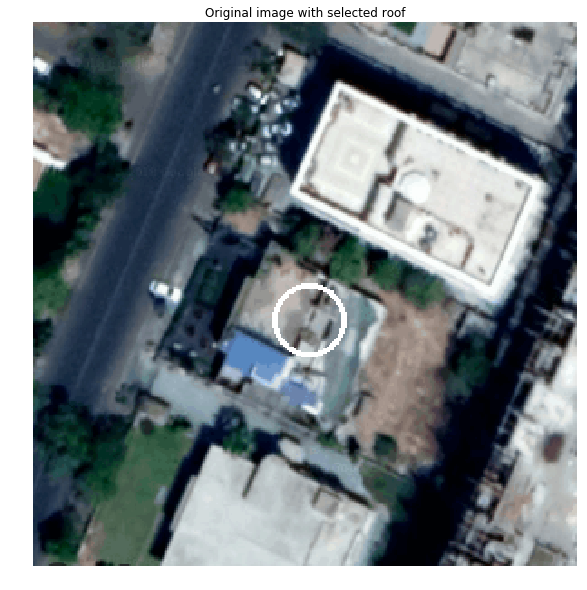

In [83]:
# SHOW USER's CLICK LOCATION
demo_image = image.copy()
print(demo_image.shape)
demo_image = cv2.circle(demo_image, coords[0], CIRCLE_SIZE, (255,255,255), 2)
plt.figure(figsize=(10,10))
plt.imshow(demo_image)
plt.axis('off')
plt.title('Original image with selected roof');

### Apply the user's given click

[INFO] 1 unique segments found


(300, 300)

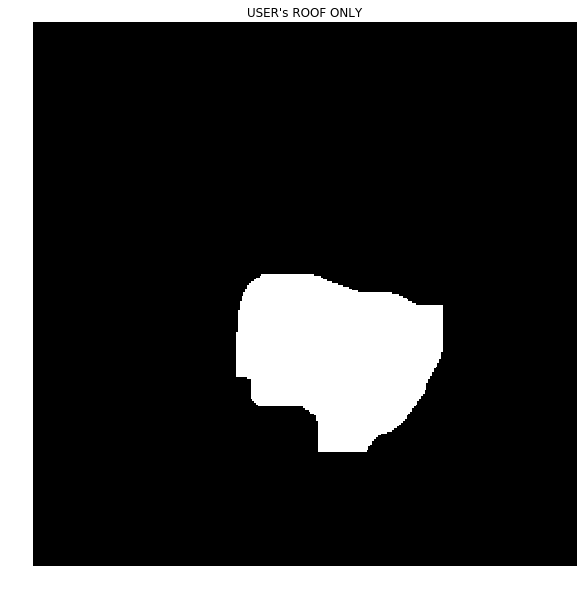

In [84]:
# apply the Watershed algorithm
labels = watershed(-D, markers, mask=thresh)
labels[labels != labels[coords[0][1], coords[0][0]]] = 0
labels = labels.astype(np.uint8)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))
# DISPLAY IMAGE
plt.figure(figsize=(10,10))
plt.imshow(labels, cmap='gray')
plt.axis('off')
plt.title("USER's ROOF ONLY")
labels.shape

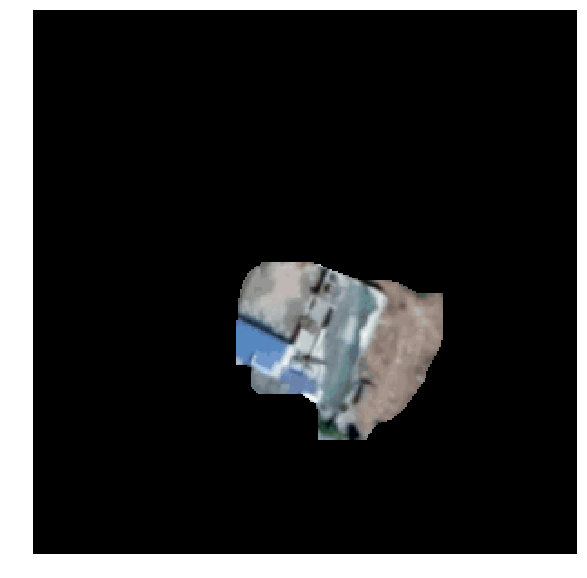

In [85]:
user_roof = cv2.bitwise_and(image, image, mask=labels)
# DISPLAY IMAGE
plt.figure(figsize=(10,10))
plt.imshow(user_roof)
plt.axis('off')
plt.show()